# <p style="text-align: center;"> Deep-Learning Mini-Project 1 : </p>
# <p style="text-align: center;"> Image Classification and Regression </p>

#### <p style="text-align: center;"> Clément RIU - clement.riu@eleves.enpc.fr</p>

#### <p style="text-align: center;"> 07/12/2018 </p>


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.utils.np_utils import to_categorical



# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1:
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]


def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = to_categorical(Y_test, 3)
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

Using TensorFlow backend.


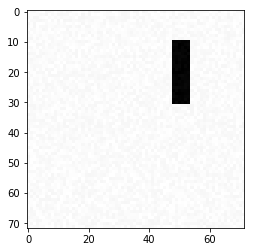

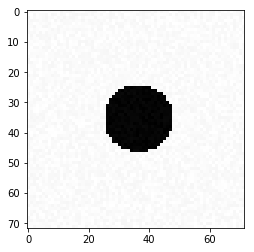

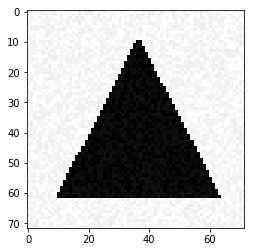

In [2]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

## 3 Simple Classification

In [3]:
NB_image = 300

In [4]:
[X_train, Y_train] = generate_dataset_classification(NB_image, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [5]:
Y_train_bin = to_categorical(Y_train)

In [6]:
from keras.optimizers import SGD, Adam
sgd = SGD(lr=0.001,
          decay=1e-6,
          momentum=0.9,
          nesterov=True)
adam = Adam(lr=0.0001,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=None,
            decay=0.0,
            amsgrad=False)

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Activation
nb_neurons1 = 3
model = Sequential([
    Dense(nb_neurons1, input_shape=(X_train.shape[1],)),
    Activation('softmax'),
])

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam')

In [9]:
epochs=50

In [10]:
model.fit(X_train, Y_train_bin, epochs=epochs, batch_size=32)

Epoch 1/50
300/300 [==============================] - 0s 533us/step - loss: 2.3181
Epoch 2/50
300/300 [==============================] - 0s 67us/step - loss: 1.0857
Epoch 3/50
300/300 [==============================] - 0s 77us/step - loss: 0.6998
Epoch 4/50
300/300 [==============================] - 0s 71us/step - loss: 0.4884
Epoch 5/50
300/300 [==============================] - 0s 80us/step - loss: 0.3829
Epoch 6/50
300/300 [==============================] - 0s 69us/step - loss: 0.4493
Epoch 7/50
300/300 [==============================] - 0s 76us/step - loss: 0.3448
Epoch 8/50
300/300 [==============================] - 0s 66us/step - loss: 0.2720
Epoch 9/50
300/300 [==============================] - 0s 88us/step - loss: 0.2326
Epoch 10/50
300/300 [==============================] - 0s 74us/step - loss: 0.1948
Epoch 11/50
300/300 [==============================] - 0s 80us/step - loss: 0.1703
Epoch 12/50
300/300 [==============================] - 0s 79us/step - loss: 0.1622
Epoch 13/50


In [11]:
X_test0 = generate_a_rectangle()
print(X_test0)
X_test0 = X_test0.reshape(1, X_test0.shape[0])
model.predict(X_test0)

[255. 255. 255. ... 255. 255. 255.]


array([[1., 0., 0.]], dtype=float32)

In [12]:
X_test2 = generate_a_disk()
print(X_test2)
X_test2 = X_test2.reshape(1, X_test2.shape[0])
model.predict(X_test2)

[255. 255. 255. ... 255. 255. 255.]


array([[0., 1., 0.]], dtype=float32)

In [13]:
X_test1 = generate_a_triangle()[0]
print(X_test1)
X_test1 = X_test1.reshape(1, X_test1.shape[0])
model.predict(X_test1)

[255. 255. 255. ... 255. 255. 255.]


array([[0., 0., 1.]], dtype=float32)

We observe on the three different forms the expected output : $[1, 0, 0]$ for rectangle, $[0, 1, 0]$ for disk and $[0, 0, 1]$ for triangle.

## 4 Visualisation of the Solution

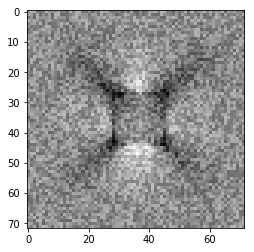

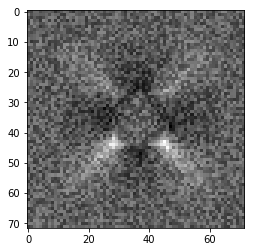

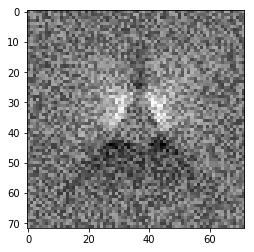

In [14]:
weights = model.get_weights()[0]
for i in range (weights.shape[1]):
    im = weights[:, i]
    plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    plt.show()

We can clearly see the different shapes appear in the weights matrix.

## 5 A More Difficult Classification Problem

In [15]:
NB_image = 3000

In [16]:
[X_train, Y_train] = generate_dataset_classification(NB_image, 20, True)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

In [17]:
Y_train_bin = to_categorical(Y_train)

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Activation
nb_neurons1 = 3
model = Sequential([
    Dense(nb_neurons1, input_shape=(X_train.shape[1],)),
    Activation('softmax'),
])

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

In [20]:
model.fit(X_train, Y_train_bin, epochs=epochs, batch_size=32)

Epoch 1/50
3000/3000 [==============================] - 0s 102us/step - loss: 1.3123 - acc: 0.4633
Epoch 2/50
3000/3000 [==============================] - 0s 61us/step - loss: 0.9021 - acc: 0.5527
Epoch 3/50
3000/3000 [==============================] - 0s 62us/step - loss: 0.9178 - acc: 0.5743
Epoch 4/50
3000/3000 [==============================] - 0s 63us/step - loss: 0.8958 - acc: 0.5640
Epoch 5/50
3000/3000 [==============================] - 0s 60us/step - loss: 0.9359 - acc: 0.5580
Epoch 6/50
3000/3000 [==============================] - 0s 62us/step - loss: 0.8493 - acc: 0.5957
Epoch 7/50
3000/3000 [==============================] - 0s 60us/step - loss: 0.8730 - acc: 0.5973
Epoch 8/50
3000/3000 [==============================] - 0s 59us/step - loss: 0.8368 - acc: 0.6123
Epoch 9/50
3000/3000 [==============================] - 0s 60us/step - loss: 0.8049 - acc: 0.6280
Epoch 10/50
3000/3000 [==============================] - 0s 63us/step - loss: 0.7509 - acc: 0.6303
Epoch 11/50
3000/3

In [21]:
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [22]:
model.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 125us/step


[0.77032888174057, 0.6333333333333333]

Here we can see that the accuracy is around $60\%$ which means the algorithm can learn a linear separation but it is not enough to completely separate the shapes.

In [23]:
X_train_carre = X_train.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)

In [24]:
X_train_carre.shape

(3000, 72, 72, 1)

In [25]:
from keras.layers import Conv2D, MaxPooling2D, Flatten

model_conv = Sequential([
    Conv2D(16, (5, 5), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)),
    Activation('tanh'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(3),
    Activation('softmax'),
])

In [26]:
model_conv.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy']
                  )

In [27]:
epochs=50

In [28]:
model_conv.fit(X_train_carre, Y_train_bin, epochs=epochs, batch_size=32)

Epoch 1/50
3000/3000 [==============================] - 4s 1ms/step - loss: 0.9173 - acc: 0.6063
Epoch 2/50
3000/3000 [==============================] - 4s 1ms/step - loss: 0.6335 - acc: 0.7630
Epoch 3/50
3000/3000 [==============================] - 4s 1ms/step - loss: 0.5404 - acc: 0.8133
Epoch 4/50
3000/3000 [==============================] - 4s 1ms/step - loss: 0.4738 - acc: 0.8377
Epoch 5/50
3000/3000 [==============================] - 4s 1ms/step - loss: 0.4271 - acc: 0.8527
Epoch 6/50
3000/3000 [==============================] - 4s 1ms/step - loss: 0.3625 - acc: 0.8980
Epoch 7/50
3000/3000 [==============================] - 6s 2ms/step - loss: 0.3228 - acc: 0.9040
Epoch 8/50
3000/3000 [==============================] - 5s 2ms/step - loss: 0.2873 - acc: 0.9163
Epoch 9/50
3000/3000 [==============================] - 4s 1ms/step - loss: 0.2549 - acc: 0.9323
Epoch 10/50
3000/3000 [==============================] - 5s 2ms/step - loss: 0.2383 - acc: 0.9343
Epoch 11/50
3000/3000 [======

In [29]:
X_test_carre = X_test.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)

In [30]:
model_conv.evaluate(X_test_carre, Y_test)

300/300 [==============================] - 0s 771us/step


[0.17670227328936258, 0.9400000007947286]

The accuracy reaches $90\%$ on the test set, which means the model learns quite well the shapes on this dataset. However, we see that accuracy on train set reaches above $99\%$ so there is some overfitting. We would need to reduce it with some sort of regularisation.

## 6 A Regression Problem

In [31]:
[X_train, Y_train] = generate_dataset_regression(NB_image, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

In [32]:
[X_test, Y_test] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


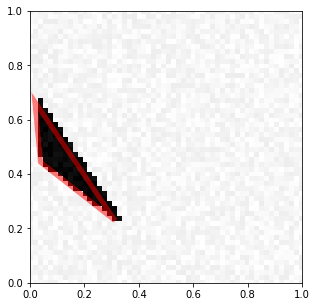

In [33]:
visualize_prediction(X_train[0], Y_train[0])

In [34]:
from operator import itemgetter
def normalize_Y(Y_train):
    Y_train_normed = np.zeros(Y_train.shape)
    for index, Y in enumerate(Y_train):
        Y_temp = sorted([[Y[2 * i], Y[2 * i + 1]] for i in range(int(len(Y) / 2))], key=itemgetter(1))
        Y_normed = []
        for tup in Y_temp:
            Y_normed += tup
        Y_train_normed[index, :] = Y_normed
    return Y_train_normed

In [35]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
nb_neurons1 = 6
model_regression = Sequential([
    Conv2D(16, (7, 7), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (7, 7)),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (7, 7)),
    Activation('relu'),
    Dropout(0.4),
    Flatten(),
    Dense(nb_neurons1),
    Activation('relu'),
])

In [36]:
model_regression.compile(loss='mean_squared_error',
                   optimizer='adam',
                  )

In [37]:
epochs=50

In [38]:
X_train_carre = X_train.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)

In [39]:
model_regression.fit(X_train_carre, normalize_Y(Y_train), epochs=epochs, batch_size=32, validation_split = 0.05, shuffle = True)

Train on 2850 samples, validate on 150 samples
Epoch 1/50
2850/2850 [==============================] - 12s 4ms/step - loss: 0.0531 - val_loss: 0.0254
Epoch 2/50
2850/2850 [==============================] - 12s 4ms/step - loss: 0.0227 - val_loss: 0.0173
Epoch 3/50
2850/2850 [==============================] - 14s 5ms/step - loss: 0.0161 - val_loss: 0.0135
Epoch 4/50
2850/2850 [==============================] - 12s 4ms/step - loss: 0.0123 - val_loss: 0.0121
Epoch 5/50
2850/2850 [==============================] - 15s 5ms/step - loss: 0.0105 - val_loss: 0.0110
Epoch 6/50
2850/2850 [==============================] - 13s 5ms/step - loss: 0.0100 - val_loss: 0.0107
Epoch 7/50
2850/2850 [==============================] - 15s 5ms/step - loss: 0.0082 - val_loss: 0.0094
Epoch 8/50
2850/2850 [==============================] - 16s 5ms/step - loss: 0.0078 - val_loss: 0.0075
Epoch 9/50
2850/2850 [==============================] - 13s 5ms/step - loss: 0.0067 - val_loss: 0.0067
Epoch 10/50
2850/2850 [===

In [40]:
model_regression.evaluate(X_test.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1), normalize_Y(Y_test))

300/300 [==============================] - 1s 2ms/step


0.0030699706388016544

In [41]:
Y_out = model_regression.predict(X_test.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1))

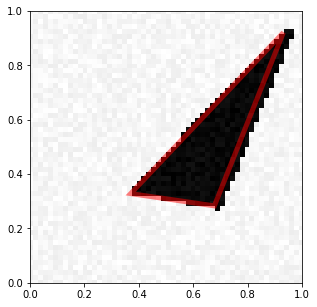

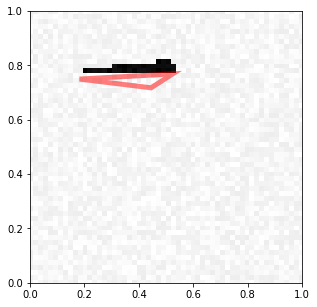

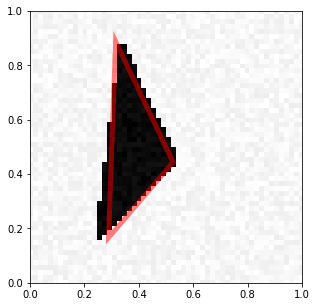

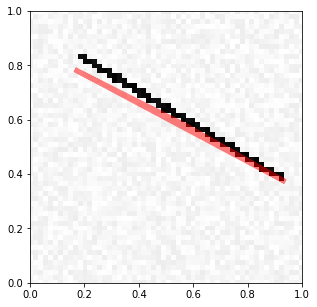

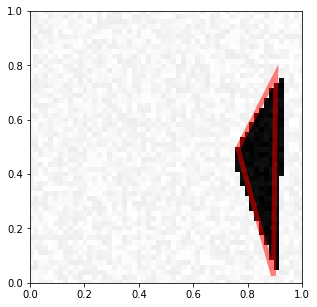

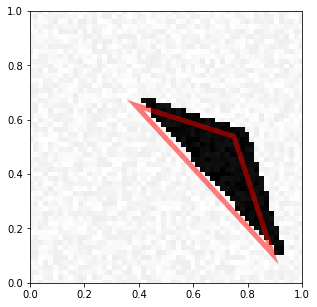

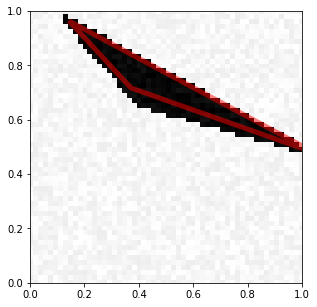

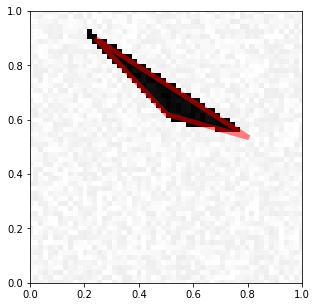

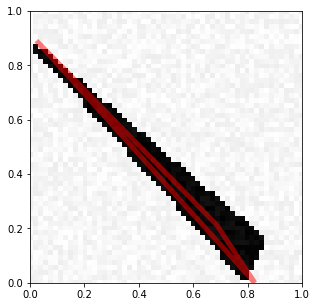

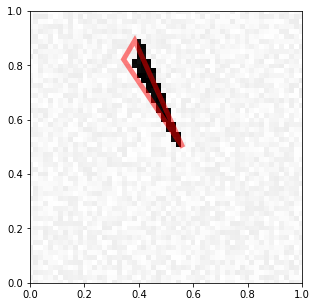

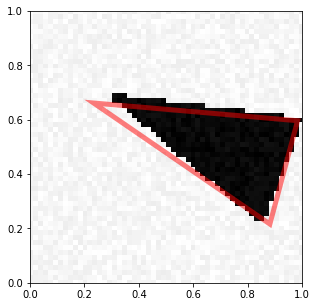

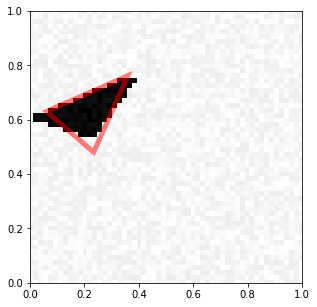

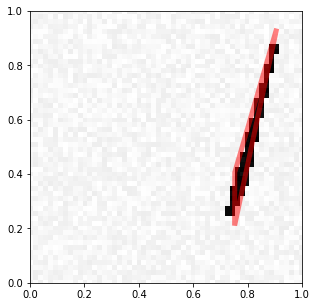

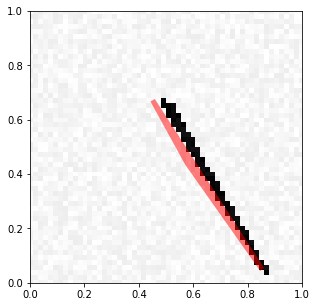

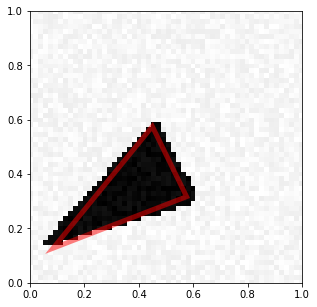

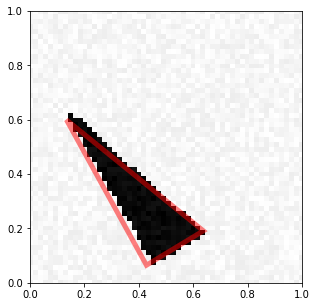

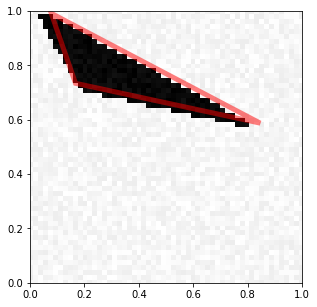

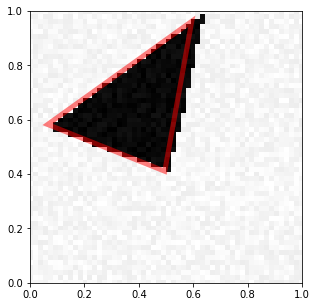

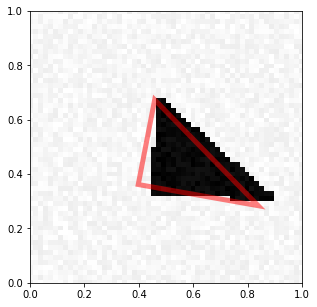

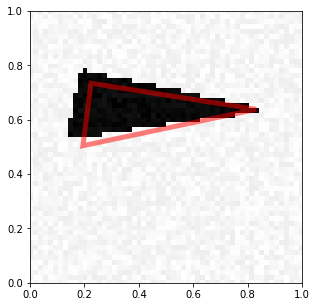

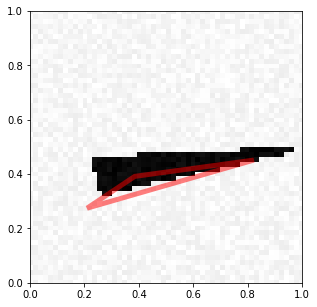

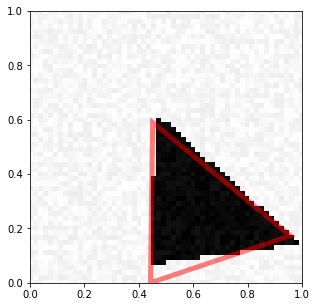

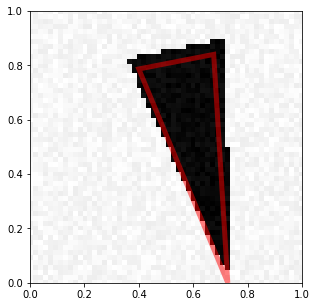

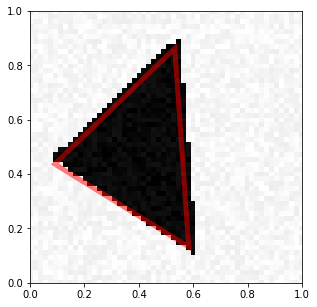

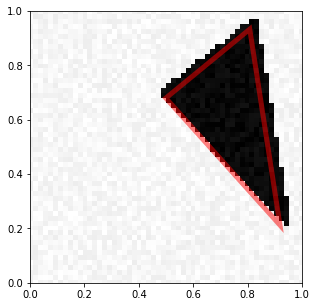

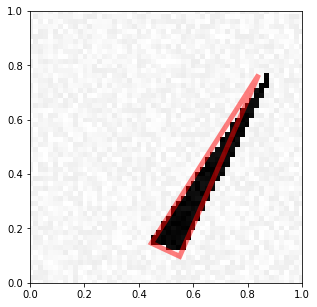

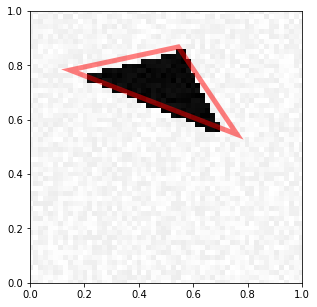

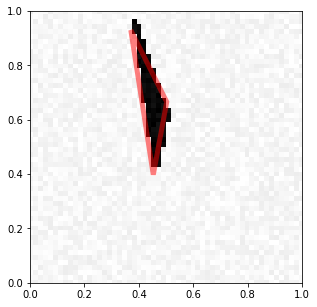

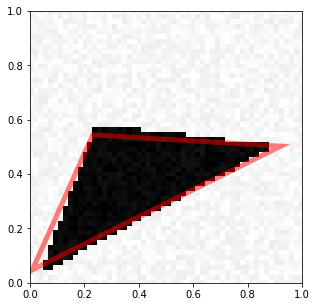

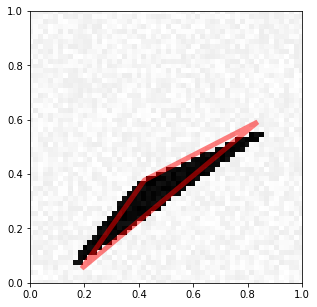

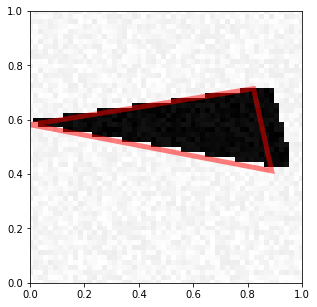

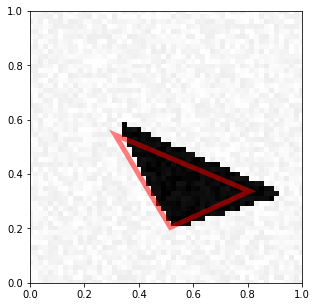

In [42]:
maxi = 30
for index, triangle in enumerate(X_test):
    visualize_prediction(triangle, Y_out[index, :])
    if index > maxi:
        break

We can see that the loss in validation is similar to the loss in test, the model does not overfit too much. However, it makes some mistakes on thin triangles and sometimes is a bit offset.

## 7 Image Denoising

In [43]:
def noisypair_generate_a_rectangle(free_location=False, noise=500.0):
    figsize = 1.0
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return [generate_a_drawing(figsize, U, V, 0.0), generate_a_drawing(figsize, U, V, noise)]

def noisypair_generate_a_disk(free_location=False, noise=500.0):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return [generate_a_drawing(figsize, U, V, 0.0), generate_a_drawing(figsize, U, V, noise)]

def noisypair_generate_a_triangle(free_location=False, noise=500.0):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, 0.0)
    imdata_noisy = generate_a_drawing(figsize, U, V, noise)
    return [imdata, imdata_noisy, [U[0], V[0], U[1], V[1], U[2], V[2]]]

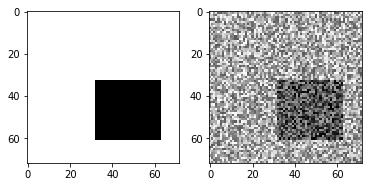

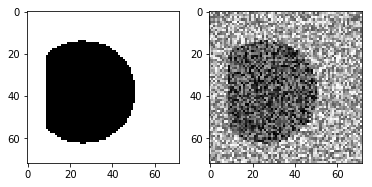

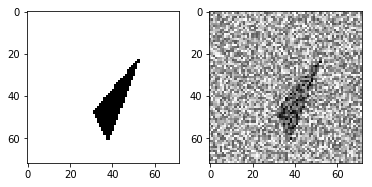

In [44]:
im, im_noisy = noisypair_generate_a_rectangle(True)
plt.subplot(1, 2, 1)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(im_noisy.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
im, im_noisy = noisypair_generate_a_disk(True)
plt.subplot(1, 2, 1)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(im_noisy.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
[im, im_noisy, v] = noisypair_generate_a_triangle(True)
plt.subplot(1, 2, 1)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(im_noisy.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

In [45]:
def generate_dataset_noisypair(Nb_image, noise_range=0):
    dataset_X = []
    dataset_Y = []
    for count in range(Nb_image):
        value = np.random.uniform()
        noise = 500
        if noise_range > 0:
            noise = np.random.randint(noise - noise_range, noise + noise_range)
        if value < 1 / 3:
            im, im_noisy = noisypair_generate_a_rectangle(True, noise=noise)
        elif value < 2 / 3:
            im, im_noisy = noisypair_generate_a_disk(True, noise=noise)
        else :
            [im, im_noisy, v] = noisypair_generate_a_triangle(True, noise=noise)
        dataset_X.append(im_noisy)
        dataset_Y.append(im)
        if count % 25 == 0:
            print(count)
    return [np.array(dataset_X).reshape(Nb_image, IMAGE_SIZE, IMAGE_SIZE, 1),
            np.array(dataset_Y).reshape(Nb_image, IMAGE_SIZE, IMAGE_SIZE, 1)]

In [46]:
NB_image = 500
noise_range = 200

In [47]:
X_train, Y_train = generate_dataset_noisypair(NB_image)
X_test, Y_test = generate_dataset_noisypair(int(NB_image / 10), noise_range=noise_range)

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475
0
25


In [48]:
from keras.models import Sequential
from keras.layers import Dense, Activation, UpSampling2D, Conv2D, MaxPooling2D, Conv2DTranspose
nb_neurons1 = 6
model_noise = Sequential([
    Conv2D(16, (4, 4), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Conv2D(16, (4, 4)),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    UpSampling2D((2, 2)),
    Conv2DTranspose(10, (5, 5)),
    Activation('relu'),
    UpSampling2D((2, 2)),
    Conv2DTranspose(10, (5, 5)),
    Activation('relu'),
    Dense(1),
])

In [49]:
model_noise.compile(loss='mean_squared_error',
                   optimizer='adam',
                  )

In [50]:
epochs = 100
model_noise.fit(X_train, Y_train, epochs=epochs, batch_size=32, validation_split = 0.1)

Train on 450 samples, validate on 50 samples
Epoch 1/100
450/450 [==============================] - 4s 8ms/step - loss: 23591.8603 - val_loss: 11494.1194
Epoch 2/100
450/450 [==============================] - 3s 7ms/step - loss: 8415.6827 - val_loss: 6048.9738
Epoch 3/100
450/450 [==============================] - 3s 7ms/step - loss: 5345.5491 - val_loss: 4468.0217
Epoch 4/100
450/450 [==============================] - 3s 7ms/step - loss: 3841.1256 - val_loss: 3091.0940
Epoch 5/100
450/450 [==============================] - 4s 10ms/step - loss: 2756.2283 - val_loss: 2302.8232
Epoch 6/100
450/450 [==============================] - 4s 9ms/step - loss: 2184.2446 - val_loss: 2011.3113
Epoch 7/100
450/450 [==============================] - 3s 7ms/step - loss: 1936.0629 - val_loss: 1822.7993
Epoch 8/100
450/450 [==============================] - 3s 8ms/step - loss: 1762.0674 - val_loss: 1675.6076
Epoch 9/100
450/450 [==============================] - 3s 8ms/step - loss: 1633.7902 - val_loss:

450/450 [==============================] - 6s 12ms/step - loss: 599.0526 - val_loss: 615.3983
Epoch 78/100
450/450 [==============================] - 5s 10ms/step - loss: 581.2202 - val_loss: 562.4985
Epoch 79/100
450/450 [==============================] - 3s 8ms/step - loss: 567.8013 - val_loss: 522.5650
Epoch 80/100
450/450 [==============================] - 3s 7ms/step - loss: 560.7257 - val_loss: 524.5084
Epoch 81/100
450/450 [==============================] - 3s 7ms/step - loss: 553.4344 - val_loss: 517.3494
Epoch 82/100
450/450 [==============================] - 3s 7ms/step - loss: 547.7540 - val_loss: 535.7749
Epoch 83/100
450/450 [==============================] - 3s 7ms/step - loss: 556.9944 - val_loss: 517.9120
Epoch 84/100
450/450 [==============================] - 4s 9ms/step - loss: 542.9452 - val_loss: 521.0847
Epoch 85/100
450/450 [==============================] - 4s 10ms/step - loss: 545.4566 - val_loss: 507.0379
Epoch 86/100
450/450 [==============================] - 

In [51]:
model_noise.evaluate(X_test, Y_test)

50/50 [==============================] - 0s 3ms/step


1404.91193359375

In [52]:
Y_out = model_noise.predict(X_test)

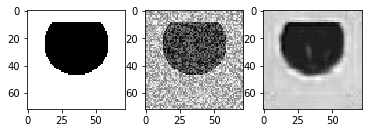

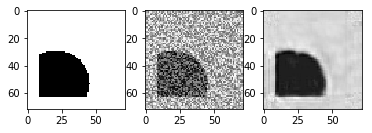

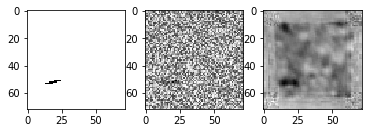

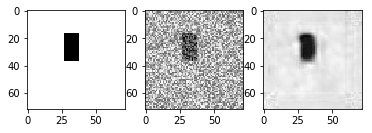

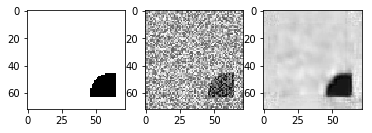

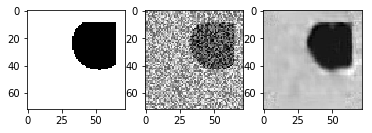

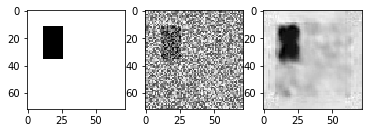

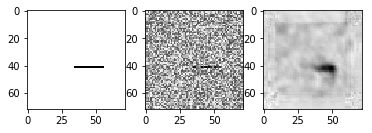

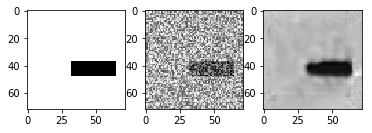

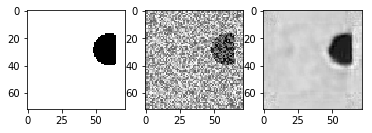

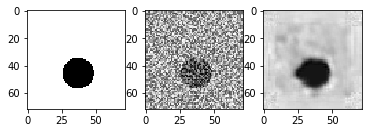

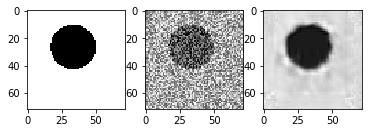

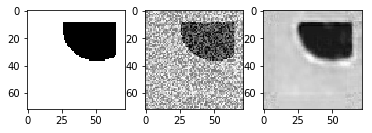

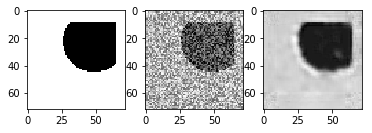

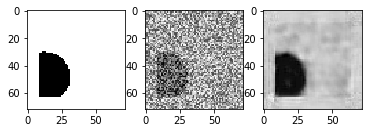

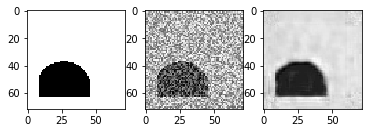

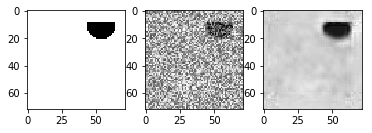

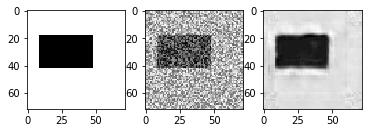

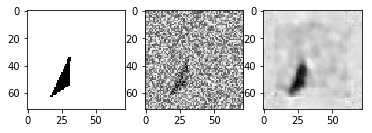

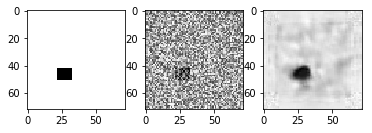

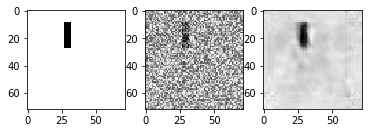

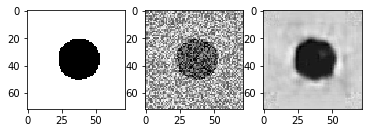

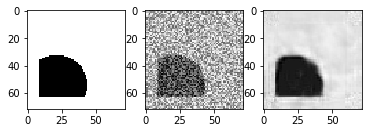

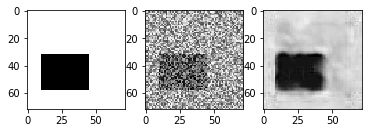

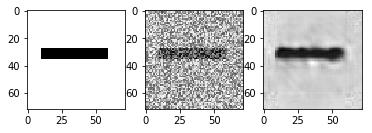

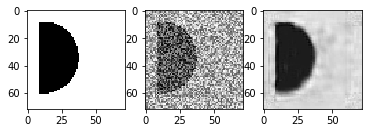

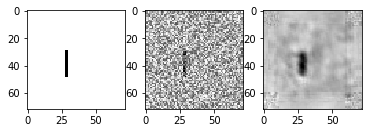

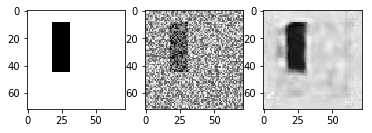

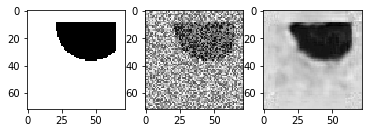

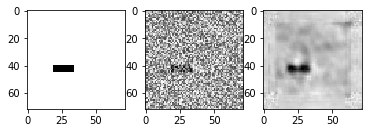

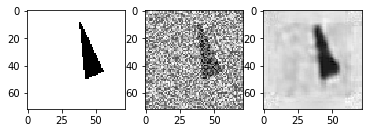

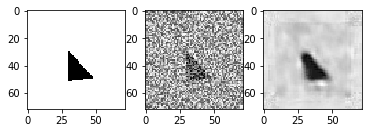

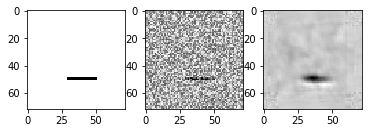

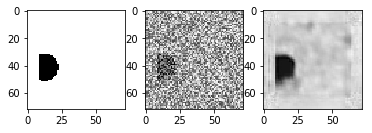

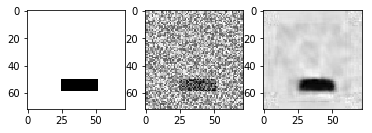

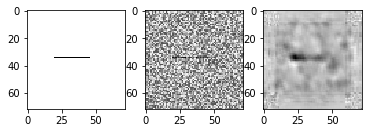

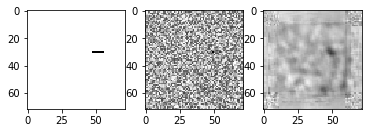

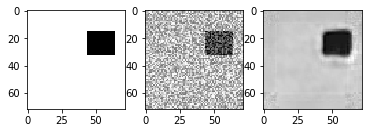

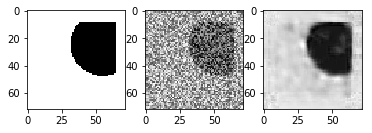

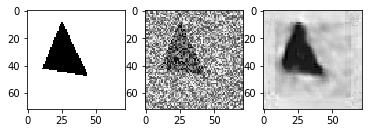

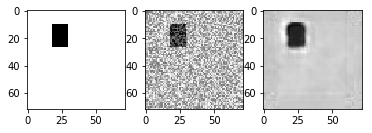

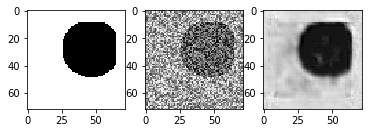

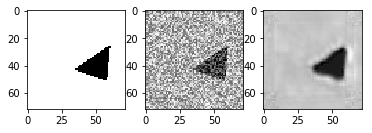

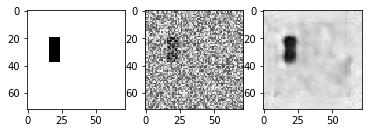

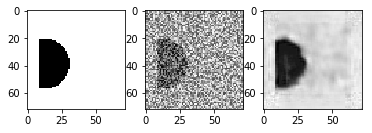

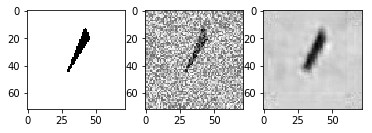

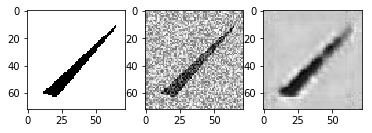

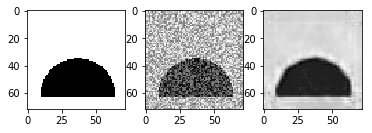

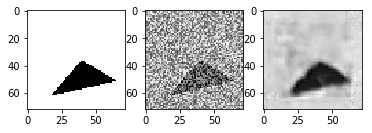

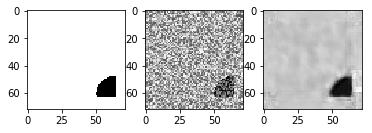

In [53]:
maxi = 50
for index, (im, im_noisy, im_out) in enumerate(zip(Y_test, X_test, Y_out)):
    plt.subplot(1, 3, 1)
    plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    plt.subplot(1, 3, 2)
    plt.imshow(im_noisy.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.imshow(im_out.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    plt.show()
    if index > maxi:
        break

The edges are blurry but the noise reduction is effective. However when the shape is small, the output is very different from the original.